# Import libraries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

from tqdm import tqdm_notebook

# %matplotlib inline
%matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

# Load data

In [23]:
# define path to dataset

# path to file in guanaco
pathToFile = "/home/shared/astro/PLAsTiCC/"

# path to file in local 
# pathToFile = "/home/leo/Downloads/plasticc_torch/"

## Loading dataset with pytorch tool

In [24]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=[16, 92])

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 3 csv files at given path


# Ploting one light curve

In [25]:
# lc_data, lc_label, lc_plasticc_id = torch_dataset_lazy.__getitem__(123)
# display(lc_plasticc_id, lc_label)
# 6 bands: u g r i z Y
# 4 sequences: mjd, flux, error, mask
# 72 samples
# display(lc_data.shape, lc_data.dtype)
# print(lc_data.detach().numpy()[0, 0, :])

In [27]:
# plot_light_curve(torch_dataset_lazy, index_in_dataset=1234)

# Spliting data (train/test)

In [28]:
# Spliting the data

# selecting train splitting
train_size = int(0.8 * torch_dataset_lazy.__len__())

# getting test splitting
test_size = torch_dataset_lazy.__len__() - train_size

# spliting the torch dataset
trainDataset, testDataset = torch.utils.data.random_split(torch_dataset_lazy, [train_size, test_size])

## Create a dataloader

In [29]:
# # Create data loader (minibatches)

# # train loader
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=256, shuffle=True)

# # test loader
testLoader = torch.utils.data.DataLoader(testDataset)
# trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

In [30]:
# check data loader shape

# training
print("#### TRAINING ####")
print("minibatches trainig: ", len(list(trainLoader)))
print("minibatch trainig size: ", list(trainLoader)[0][0].shape)


# testing
print("\n#### TESTING ####")
print("minibatches test: ", len(list(testLoader)))
print("minibatch trainig size: ", list(testLoader)[0][0].shape)

#### TRAINING ####
minibatches trainig:  98
minibatch trainig size:  torch.Size([256, 6, 4, 72])

#### TESTING ####
minibatches test:  6223
minibatch trainig size:  torch.Size([1, 6, 4, 72])


## Define autoencoder structure
To start with the work, It is going to build a very basic Autoencoder

In [82]:
# Buiding autoencoder

# Assuming this has a normal distrubtion in the latent part

# encoder
class Encoder(torch.nn.Module):
    
    # init method
    def __init__(self, latent_dim, hidden_dim, input_dim):

        super(Encoder, self).__init__()
        
        # 1 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv1 = torch.nn.Conv1d(1,64,3)
        
        # this is to consider time and magnitude
        # we should use shared weights?
        self.conv1Time = torch.nn.Conv1d(1, 64, 3)
        self.conv1Mag = torch.nn.Conv1d(1, 64, 3)
        
        # 2 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv2 = torch.nn.Conv1d(64, 32, 3)
        
        # time and magnitude conv
        self.conv2Time = torch.nn.Conv1d(64, 32, 3)
        self.conv2Mag = torch.nn.Conv1d(64, 32, 3)
        
        # linear layer
        self.hidden1 = torch.nn.Linear(2144*2, hidden_dim)
        
        # mu
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        
        # sigma
        self.logVar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()

    # forward method
    def forward(self, x):
        
        # input shape: [batch_size, channels, sequence_length]
        # print("input shape: {0}".format(x.shape))
        
        
        # convolution 1
        # x -> conv -> act -> ouput
        # shape should be: [batch_size, number of ouput channels (64), length of output from convolution]

        #conv to time
        outputTimeConv = self.activationConv(self.conv1Time(x[:, 0, :].unsqueeze(1)))
        
        # conv to magnitude
        outputMagConv = self.activationConv(self.conv1Mag(x[:, 0, :].unsqueeze(1)))
        
#         print("output conv1 shape: {0}".format(outputMagConv.shape))
#         print("output conv1 shape: {0}".format(outputTimeConv.shape))
        
        # convolution 2
#         # shape should be: [batch_size, number of ouput channels (32), length of output from convolution]
        
        # conv to time
        outputTimeConv = self.activationConv(self.conv2(outputTimeConv))
    
        # conv to flux
        outputMagConv = self.activationConv(self.conv2(outputMagConv))
        
#         print("output conv2 shape: {0}".format(outputTimeConv.shape))
#         print("output conv2 shape: {0}".format(outputMagConv.shape))
        
        # flatten ouput
        # shape should be: [batch_size, -1]
        outputMagConv = outputMagConv.view(outputMagConv.shape[0], -1)
        outputTimeConv = outputTimeConv.view(outputTimeConv.shape[0], -1)
        
#         print("output reshape: ", outputMagConv.shape)
#         print("output reshape: ", outputTimeConv.shape)
                
        # concatenate 2 towers
        output = torch.cat((outputMagConv, outputTimeConv), 1)
#         print("concatenate output shape: ", output.shape)
        
        # x -> hidden1 -> activation
        output = self.activationLinear(self.hidden1(output))
#         print("hidden1 output shape: {0}".format(output.shape))
        
        # get mu
        # sin tangenteh!!!
        mu = self.mu(output)
#         print("mu shape: {0}".format(mu.shape))
        
        # get sigma
        logVar = self.logVar(output)
#         print("sigma shape: {0}".format(logVar.shape))
        
        # returning values
        return mu, logVar

    
# decoder    
class Decoder(torch.nn.Module):
    
    # define layers
    def __init__(self, latent_dim, hidden_dim, output_dim):
        
        super(Decoder, self).__init__()
        
        # linear layer
        self.hidden1 = torch.nn.Linear(latent_dim, 2144*2)
        
        # 1 ConvolutionTrans layer
        self.convTrans1 = torch.nn.ConvTranspose1d(32, 64, 3)
        
        # 2 ConvolutionTrans layer
        self.convTrans2 = torch.nn.ConvTranspose1d(64, 1, 3)

        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()
        
    # forward method
    def forward(self, z):
        
#         print("input dimension decoder: {0}".format(z.shape))
        
        # linear (from latent to hidden dimension)
        # z -> linaer layer -> activation -> output
        output = self.activationLinear(self.hidden1(z))
#         print("output hidden1: {0}".format(output.shape))
        
        # split data (into time and flux)
        outputTimeDeconv, outputMagDeconv = torch.split(output, 2144, dim=2)
            
        # reshape each tower (time and magnitude)
        outputTimeDeconv = outputTimeDeconv.view(outputTimeDeconv.shape[0], 32, -1)
        outputMagDeconv = outputMagDeconv.view(outputMagDeconv.shape[0], 32, -1)
        
#         print("output reshape: {0}".format(outputTimeDeconv.shape))
#         print("output reshape: {0}".format(outputMagDeconv.shape))
        
        # 1 convolution
        outputTimeDeconv = self.activationConv(self.convTrans1(outputTimeDeconv))
        outputMagDeconv = self.activationConv(self.convTrans1(outputMagDeconv))
#         print("ouput convTrans1: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans1: {0}".format(outputMagDeconv.shape))
        
        # 2 convolution
        outputTimeDeconv = self.convTrans2(outputTimeDeconv)
        outputMagDeconv = self.convTrans2(outputMagDeconv)
        
#         print("ouput convTrans2: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans2: {0}".format(outputMagDeconv.shape))
        
        # concatenate arrays in order to get the data with 2 channels
        output = torch.cat((outputTimeDeconv, outputMagDeconv), 1)
#         print("concatenate in channels: {0}".format(output.shape))

        # output
        return output

# building the autoencoder     
class AutoEncoder(torch.nn.Module):
    
    # defining the initial structure
    def __init__(self, latent_dim, hidden_dim, input_dim):
        
        super(AutoEncoder, self).__init__()
        
        # defining the encoder
        self.encoder = Encoder(latent_dim, hidden_dim, input_dim)
        
        # defining the decoder
        # note the output dimension in the decoder is the same as input dimension
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    # distribution function
    def sampling(self, mu, logvar, k = 1):
        
        # assumming normal distribution
#         s = torch.exp(0.5*sigma)
#         eps = torch.rand_like(s) # generate a iid standard normal same shape as s
#         return eps.mul(s).add_(mu)
        batch_size, n_latent = logvar.shape
        std = (0.5*logvar).exp()
#         eps = torch.randn(batch_size, k, n_latent, device=std.device, requires_grad=False)
        eps = torch.randn(batch_size, k, n_latent, requires_grad=False)
        if "cuda" in str(mu.device):
            eps = eps.cuda()
        return eps.mul(std.unsqueeze(1)).add(mu.unsqueeze(1))
    
    # forward method (how to the nn works)
    def forward(self, x):
        
#         print("input size: {0}".format(x.shape))
        
#         print("## Encoder ##")
        # input (x) -> encoder -> latent variables
        mu, logVar = self.encoder(x)
#         print("output encoder size: {0}".format(mu.shape))
        
#         print("mu ", mu.device)
#         print("var ", logVar.device)
        # getting sample
        # mu, sigma -> distribution -> z
        z = self.sampling(mu, logVar)
#         print("z shape: ", z.shape)
        
#         print("## Dencoder ##")
        # latent variables -> decoder -> reconstruction (x)
        decOutput = self.decoder(z)
#         print("output decoder size: {0}".format(decOutput.shape))
        
        return decOutput

## Defining parameters to Autoencoder

In [83]:
# check number of parameters
latentDim = 5
hiddenDim = 10
inputDim = 72

# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim)

In [84]:
# # test the model data flow
# model.forward(list(trainLoader)[0][0]).shape

In [85]:
# print("input dimension: {0}".format(len(list(trainLoader))))

# parameters number
count = 0

# # check model dimension
for name, param in model.state_dict().items():
    # name: str
    # param: Tensor
#     print("{0}: {1} \n".format(name, param.shape))
#     print(param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1))
#     print(param.shape)
    count += param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1)
# for param in model.parameters():
    
print("number of parameters: " + str(count))

number of parameters: 77529


In [86]:
from torch.nn import functional as F

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    
#     print("reconstruction: {0}".format(recon_x))
#     print("x: {0}".format(x))
#     print("mu: {0}".format(mu))
#     print("logvar: {0}".format(logvar))
    
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
#     print(BCE)
    
    return BCE + KLD

In [87]:
from torchvision import transforms

# normalize light curve
# data: [batch size, 2 channels (time and magnitude), light curve length]
def normalizeLightCurve(data):
    
#     print("data shape before normalization: ", data.shape)
    
    # get flux mean
    means = data[:, 1, :].mean(dim=1)
#     print("mean shape: ", means.shape)
    
    # get flux standar deviation 
    stds = data[:, 1, :].std(dim=1)
#     print("stds shape: ", stds.shape)
    
    # overwrite flux
    data[:, 1, :] = (data[:, 1, :] - means.unsqueeze(1).expand_as(data[:, 1, :])) / stds.unsqueeze(1).expand_as(data[:, 1, :])
#     print("normalized data shape: ", data.shape)
    
    # return normalized data
    return data

In [88]:
# function to generate delta time and flux
# data = [batchSize, channels, [time, flux, err, mask], light curve]
def generateDeltas(data, passBand):
    
    # work with delta time and magnitude
    
#     print("generate deltas input shape: {0}".format(data.shape) )
    # delta time
    tmpDeltaTime = data[:, passBand, 0, 1:] - data[:, passBand, 0, :-1]

#     print("generate deltas time shape: {0}".format(tmpDeltaTime.shape) )

#     # delta magnitude
    tmpDeltaMagnitude = data[:, passBand, 1, 1:] - data[:, passBand, 1, :-1]
#     print("generate deltas flux shape: {0}".format(tmpDeltaMagnitude.shape))
    
    # concatenate tensors
    dataToUse = torch.cat((tmpDeltaTime.unsqueeze(1), tmpDeltaMagnitude.unsqueeze(1)), 1)
#     print("data to use shape: {0}".format(dataToUse.shape))
    
    # normalize data
    dataToUse = normalizeLightCurve(dataToUse)
    
    # returning data
    return dataToUse

<IPython.core.display.Javascript object>


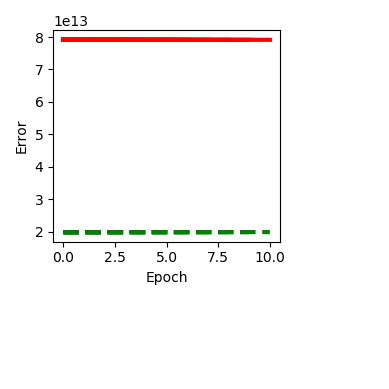

/opt/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2



KeyboardInterrupt: 

In [92]:
# loss function
# criterion = torch.nn.MSELoss(reduction = "sum")

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# use of GPU flag
use_gpu = True

# load model on GPU
if use_gpu:
    model = model.cuda()

# number of epochs
epochs = 100

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# loss plot
fig, ax = plt.subplots(figsize = (3, 3), tight_layout = True)
# fig, ax = plt.subplots()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

# plt.legend()

# plt.axis([0,1000,0,10])
# plt.show()

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 100

for nepoch in tqdm_notebook(range(epochs)):
    
    # train
    epoch_train_loss = 0
    
    for data in trainLoader:
        
        data = data[0]
        
        optimizer.zero_grad()
        
        if use_gpu:
            
#             data = data.type(torch.FloatTensor).cuda()
            data = generateDeltas(data, 0).type(torch.FloatTensor).cuda()
#             print(data.device)
#             print(model.device())
            outputs = model.forward(data)
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor).cuda())
            
        else:
                        
            data = generateDeltas(data, 0).type(torch.FloatTensor)
#             generateDeltas(data, 0)
            outputs = model.forward(data.type(torch.FloatTensor))
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor))
        
#         loss = criterion(outputs, data)
        # use KLD + MSE
        loss = loss_function(outputs, data, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_loss[nepoch] = epoch_train_loss
    
    # test
    epoch_test_loss = 0
    
    for data in testLoader:
        
        data = data[0]
        
        if use_gpu:
            
            data = generateDeltas(data, 0).type(torch.FloatTensor).cuda()
#             data = data.type(torch.FloatTensor).cuda()
            outputs = model.forward(data)
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor).cuda())
        
        else:
#             data = data.type(torch.FloatTensor)
            data = generateDeltas(data, 0).type(torch.FloatTensor)
            
            outputs = model.forward(data)
            
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor))
        
#         loss = criterion(outputs, data)
        loss = loss_function(outputs, data, mu, logvar)
        
        epoch_test_loss += loss.item()
    
    test_loss[nepoch] = epoch_test_loss
    
#     # plot loss
    ax.plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
    ax.plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green") 
    
    fig.canvas.draw()
    
        # Early stopping
    if epoch_test_loss > prior_test_error:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
    else: 
        count_early_stop = 0
    
    # update prior test error
    prior_test_error = epoch_test_loss
    
    # analyze early stopping
    if count_early_stop > threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        break

# Save model

In [93]:
!pwd

/home/lbravo/thesis/work/thesis


In [94]:
# pathToSaveModel = "/home/leo/Desktop/thesis/work/thesis/models/model"
pathToSaveModel = "/home/lbravo/thesis/work/thesis/models/model_guanaco_1"
# add guanaco path

# modelName = "model"

torch.save(model.state_dict(), pathToSaveModel)

# Load model

In [95]:
# model path
# pathToSaveModel = "/home/leo/Desktop/thesis/work/thesis/models/model"
pathToSaveModel = "/home/lbravo/thesis/work/thesis/models/model_guanaco_1"

In [96]:
# check number of parameters
latentDim = 5
hiddenDim = 10
inputDim = 72

# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim)

# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(pathToSaveModel))

<All keys matched successfully>

# Check reconstructed light curve

98


<IPython.core.display.Javascript object>


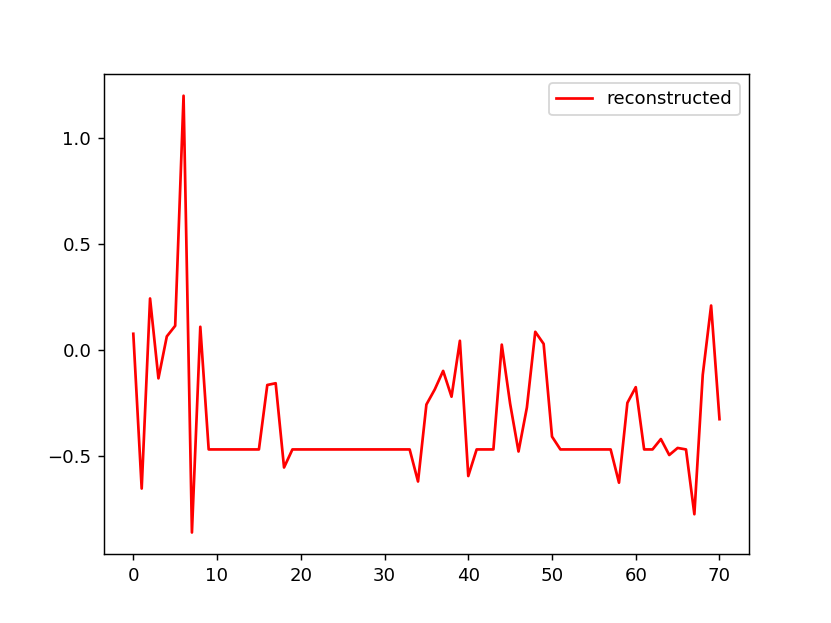

In [97]:
# reconstruction
print(len(list(trainLoader)))

lID = 0

reconstructedLightCurve = model.forward(generateDeltas(list(trainLoader)[lID][0], 0))

# print(reconstructedLightCurve.shape)
# print(list(testLoader)[0][0].shape)
# # display(reconstructedLightCurve.detach().numpy()[0].shape)
# print(list(testLoader)[0][0][0, 1, :].shape)

fig, ax = plt.subplots()

ax.plot(reconstructedLightCurve.detach().numpy()[0, 1, :], label = "reconstructed", color = "red")

# ax.plot(list(trainLoader)[lID][0][0, 1, :].detach().numpy(), label = "original", color = "green")

plt.legend()

### <font color='red'>Things to do:</font>
- Define metrics for evaluate models